In [43]:
import sys 
import os
import numpy as np
import itertools
from dataclasses import dataclass
from matplotlib import pyplot as plt
from typing import Optional, Mapping, Dict, Tuple

sys.path.append(os.path.abspath("/Users/quinnhollister/RL-book/rl/markov_process.py"))
from rl import markov_process
from rl.distribution import Categorical, Constant, Categorical, FiniteDistribution
from rl.markov_process import FiniteMarkovProcess, NonTerminal, MarkovRewardProcess, FiniteMarkovRewardProcess
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.policy import FiniteDeterministicPolicy

#Question 3, Need to code the Frog Question as an FMDP




@dataclass(frozen=True)
class lily:
    position: int
        
        
ActionMapping = Mapping[lily, Mapping[int, Categorical[Tuple[lily, float]]]]
        
    
    
class FrogEscape(FiniteMarkovDecisionProcess[lily, int]):
    
    def __init__(self, lilySize: int):
        self.lilySize = lilySize
        super().__init__(self.get_action_transition_reward_map())
        
        
    def get_action_transition_reward_map(self) -> ActionMapping:
        d: Dict[lily, Dict[int, Categorical[Tuple[lily, float]]]] = {}
        
        for s in range(1,self.lilySize):
            di: Dict[int, Categorical[Tuple[lily,float]]] = {}
            #A->0, B->1
            for action in list([0,1]):  
                state_prob_map: Mapping[Tuple[lily,float], float] = {}
                #Flesh out action A
                if action == 0:
                    if s == 1:
                        state_prob_map[(lily(s-1), 0)] = s/self.lilySize
                        state_prob_map[(lily(s+1), 0)] = (self.lilySize-s)/self.lilySize
                    elif s == self.lilySize - 1:
                        state_prob_map[(lily(s+1),1)] = (self.lilySize - s)/self.lilySize
                        state_prob_map[(lily(s-1),0)] = s/self.lilySize
                    else:
                        state_prob_map[(lily(s-1), 0)] = s/self.lilySize
                        state_prob_map[(lily(s+1), 0)] = (self.lilySize - s)/self.lilySize
                #Flesh out action B
                if action == 1: 
                    for sprime in range(0, self.lilySize + 1):
                        if sprime == s:
                            continue
                        if sprime == 0:
                            state_prob_map[(lily(sprime), 0)] = 1/self.lilySize
                        elif sprime == self.lilySize -1:    
                             state_prob_map[(lily(sprime), 1)] = 1/self.lilySize
                        else:
                            state_prob_map[(lily(sprime), 0)] = 1/self.lilySize
                di[action] = Categorical(state_prob_map)
            d[lily(s)] = di
        return d
    





In [44]:
#Lets check that the code does what we want it to do:

Frog3 = FrogEscape(3)
print(Frog3)

From State lily(position=1):
  With Action 0:
    To [Terminal State lily(position=0) and Reward 0.000] with Probability 0.333
    To [State lily(position=2) and Reward 0.000] with Probability 0.667
  With Action 1:
    To [Terminal State lily(position=0) and Reward 0.000] with Probability 0.333
    To [State lily(position=2) and Reward 1.000] with Probability 0.333
    To [Terminal State lily(position=3) and Reward 0.000] with Probability 0.333
From State lily(position=2):
  With Action 0:
    To [Terminal State lily(position=3) and Reward 1.000] with Probability 0.333
    To [State lily(position=1) and Reward 0.000] with Probability 0.667
  With Action 1:
    To [Terminal State lily(position=0) and Reward 0.000] with Probability 0.333
    To [State lily(position=1) and Reward 0.000] with Probability 0.333
    To [Terminal State lily(position=3) and Reward 0.000] with Probability 0.333



In [45]:
#Now we need to write code that creates the full set of deterministic policies for a given n


def gen_fdp(lilySize, actionVec):
    fdp = FiniteDeterministicPolicy(
        {lily(s): action for s, action in zip(range(1, lilySize), actionVec)}
    )
    return fdp



print(gen_fdp(3, [0,1]))

For State lily(position=1): Do Action 0
For State lily(position=2): Do Action 1



In [46]:
#As long as we provide an actionVec, we can get the implied MRP through the FMDP function, now lets create
#each of these determinstic policies for a given n, and then to find the optimal Value Func and Policy

def order(vec1, vec2):
    partial = [i > j for i,j in zip(vec1,vec2)]
    for i in partial:
        if i == False:
            return False
    return True


def optimal_frog(lilySize):
    #First create the deterministic policies, and the associated MDP:
    policies = list(itertools.product([0,1], repeat = lilySize))
    Frog = FrogEscape(lilySize)
    
    
    #Now lets effectively do a grid search to find the best value func and thus policy. Need to initialize first
    max_value_func = [0]*(lilySize-1)
    max_policy = None

    for policy in policies:
        fdp = gen_fdp(lilySize, policy)
        implied_mrp = Frog.apply_finite_policy(fdp)
        value_func = implied_mrp.get_value_function_vec(gamma = 1)
        
        #Now, lets check if value func is optimal
        
        if order(value_func, max_value_func) == True:
            max_value_func = value_func
            max_policy = fdp
    
    return max_policy, max_value_func
    
    

    
    
    


In [78]:
OptFrog3 = optimal_frog(3)
OptFrog6 = optimal_frog(6)
OptFrog9 = optimal_frog(9)







print(OptFrog3[1])
print(OptFrog6[1])
print(OptFrog9[1])

[0.57142857 0.71428571]
[0.65957447 0.70212766 0.72340426 0.74468085 0.78723404]
[0.67567568 0.70523649 0.71368243 0.71790541 0.72128378 0.72550676
 0.7339527  0.76351351]


Text(0, 0.5, 'Probabililty of escape for optimal policy')

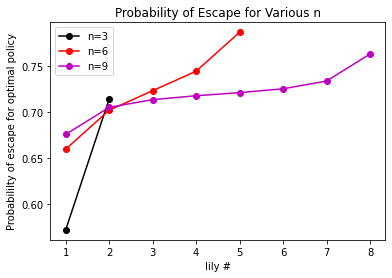

In [82]:
#Now lets plot prob of escape for these three different frog games:\
x_axis_3 = [str(x) for x in range(1, 3)]
x_axis_6 = [str(x) for x in range(1, 6)]
x_axis_9 = [str(x) for x in range(1, 9)]

                         
game3 = plt.plot(x_axis_3, OptFrog3[1], 'ko-', label = "n=3")
game6 = plt.plot(x_axis_6, OptFrog6[1], 'ro-', label = "n=6")
game9 = plt.plot(x_axis_9, OptFrog9[1], 'mo-', label = "n=9")

plt.legend()

plt.title("Probability of Escape for Various n")
plt.xlabel("lily #")
plt.ylabel("Probabililty of escape for optimal policy")


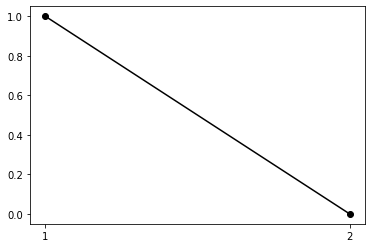

In [97]:
#Now lets plot a graph of the optimal croak

#print(OptFrog3[0].action_for[lily(1)])
policy3 = [OptFrog3[0].action_for[lily(i)] for i in range(1,3)]
policy6 = [OptFrog6[0].action_for[lily(i)] for i in range(1,6)]
policy9 = [OptFrog9[0].action_for[lily(i)] for i in range(1,9)]


plot1 = plt.plot(x_axis_3, policy3, 'ko-', label = "n=3")
plot2 = plt.plot(x_axis_6, policy6, 'ro-', label = "n=6")
plot3 = plt.plot(x_axis_9, policy9, 'mo-', label = "n=9")

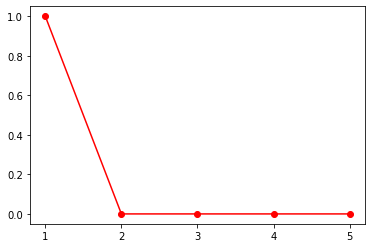

In [98]:
plot2 = plt.plot(x_axis_6, policy6, 'ro-', label = "n=6")

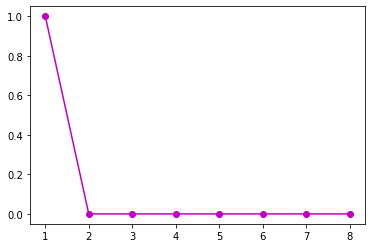

In [99]:
plot3 = plt.plot(x_axis_9, policy9, 'mo-', label = "n=9")